<a href="https://colab.research.google.com/github/UjalaJha/NasaSpaceAppChallenge/blob/master/Fire_detection_classification/Empedrado_Chile_fire_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthpy gdal seaborn geopandas rasterio lightgbm

     |████████████████████████████████| 1.4MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 972kB 16.9MB/s 
     |████████████████████████████████| 18.1MB 1.4MB/s 
     |████████████████████████████████| 14.8MB 180kB/s 
     |████████████████████████████████| 10.9MB 45.5MB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=89e76855d74baa76c37fcf680324152f8f3d18889122d50c71456559fc4cf439
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [2]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import gdal 

import geopandas as gpd
from shapely.geometry import mapping, box

import pandas as pd

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# sns.set_style('white')
# sns.set(font_scale=1.5)      

In [3]:
def show_band(img, title='', size=(6,6), cmap='viridis'):
  # colors = ["g", "yellowgreen",
  #             "peachpuff", "coral", "maroon"]
  # cmap = ListedColormap(colors)
  print(title+' Shape: ', img.shape)
  fig = plt.figure(figsize=size)
  plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap= cmap)
  plt.axis('off')
  plt.colorbar()
  plt.title(title)
  plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## prepare Data

In [5]:
with rio.open('/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/sentinel-post-fire/T18HYF_20170218T143751_B8A.jp2') as f1_af:
  b8A = f1_af.read()

with rio.open('/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/sentinel-post-fire/T18HYF_20170218T143751_B12.jp2') as f2_af:
  b12 = f2_af.read()

with rio.open('/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/dnbr.tiff') as f3_af:
  dnbr = f3_af.read()

with rio.open('/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/empedrado_final.tiff') as f4_gt:
  gt = f4_gt.read()

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


NIR Band(B8A) Shape:  (5490, 5490)


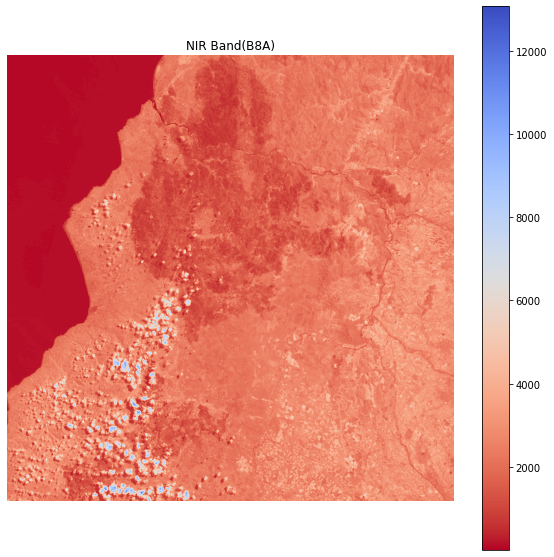

SWIR Band(B12) Shape:  (5490, 5490)


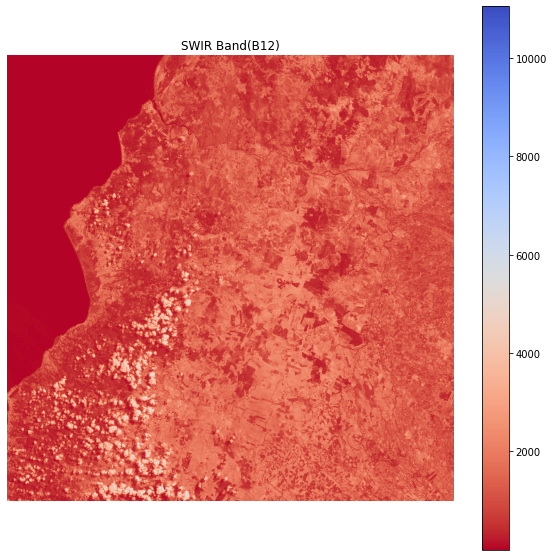

DNBR Shape:  (5490, 5490)


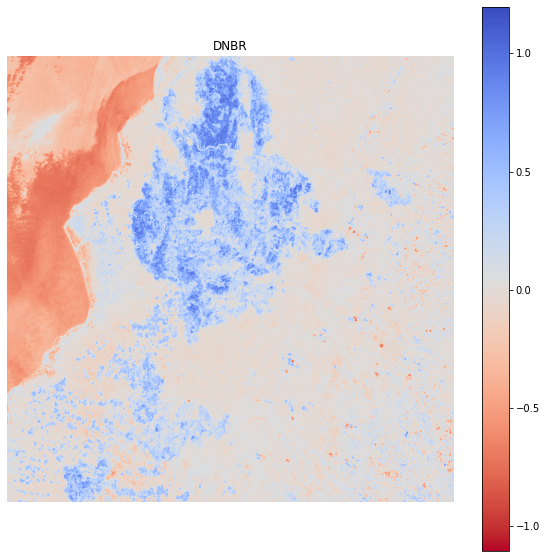

Ground Truth Shape:  (5490, 5490)


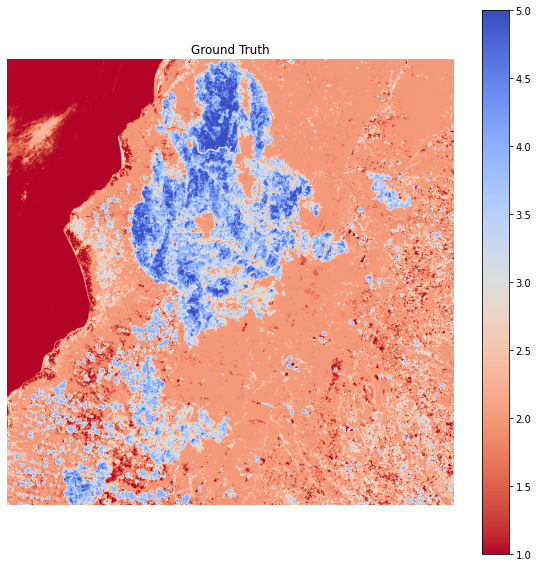

In [6]:
show_band(b8A.reshape(b8A.shape[1:]), title='NIR Band(B8A)', size=(10,10), cmap='coolwarm_r')

show_band(b12.reshape(b12.shape[1:]), title='SWIR Band(B12)', size=(10,10), cmap='coolwarm_r')

show_band(dnbr.reshape(dnbr.shape[1:]), title='DNBR', size=(10,10), cmap='coolwarm_r')

show_band(gt.reshape(gt.shape[1:]), title='Ground Truth', size=(10,10), cmap='coolwarm_r')

## Crate a dataset

In [7]:
sz = gt.shape

df = pd.DataFrame(columns=['b8A', 'b12', 'dnbr', 'groundTruth'])

df['b8A'] = b8A.reshape(b8A.shape[1:]).astype('float32').ravel()

df['b12'] = b12.reshape(b12.shape[1:]).astype('float32').ravel()

df['dnbr'] = dnbr.reshape(dnbr.shape[1:]).ravel()

df['groundTruth'] = gt.reshape(gt.shape[1:]).ravel().astype(int)-1

In [8]:
df.head()

,b8A,b12,dnbr,groundTruth
0,117.0,21.0,-0.542874,0
1,97.0,11.0,-0.651018,0
2,107.0,16.0,-0.604954,0
3,96.0,25.0,-0.438497,0
4,94.0,21.0,-0.473075,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30140100 entries, 0 to 30140099
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   b8A          float32
 1   b12          float32
 2   dnbr         float32
 3   groundTruth  int64  
dtypes: float32(3), int64(1)
memory usage: 574.9 MB


In [10]:
df.describe()

,b8A,b12,dnbr,groundTruth
count,3.014010e+07,3.014010e+07,3.014010e+07,3.014010e+07
mean,2.249908e+03,1.078303e+03,1.786192e-02,1.246459e+00
std,1.189079e+03,8.165435e+02,2.882600e-01,1.002303e+00
min,1.000000e+00,1.000000e+00,-1.104352e+00,0.000000e+00
25%,1.286000e+03,4.280000e+02,-5.865131e-02,1.000000e+00
50%,2.208000e+03,1.001000e+03,4.424340e-03,1.000000e+00
75%,2.733000e+03,1.695000e+03,1.110908e-01,2.000000e+00
max,1.307800e+04,1.104600e+04,1.195333e+00,4.000000e+00


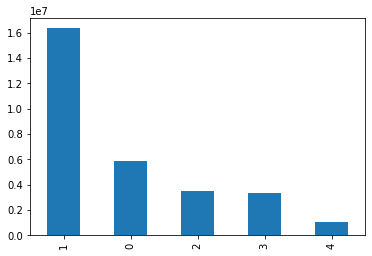

In [11]:
df.groundTruth.value_counts().plot(kind = 'bar')
plt.show()

In [12]:
# df.to_csv('flood_dataset.csv', index=False)

## Ml Model

we are using **lightbgm**

In [13]:
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

In [14]:
# df = pd.read_csv('flood_dataset.csv')

In [15]:
df.head()

,b8A,b12,dnbr,groundTruth
0,117.0,21.0,-0.542874,0
1,97.0,11.0,-0.651018,0
2,107.0,16.0,-0.604954,0
3,96.0,25.0,-0.438497,0
4,94.0,21.0,-0.473075,0


In [16]:
x = df.iloc[:, :-1].values

y = df.iloc[:, -1].values

print(f'Data Shape: {x.shape}\nLabel Shape:{y.shape}')

Data Shape: (30140100, 3)
Label Shape:(30140100,)


In [17]:
#scaling the features using Standard Scaler

sc=StandardScaler()

sc.fit(x)

X=sc.fit_transform(x)

In [18]:
#train_test_split 

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=11, stratify = y)

In [19]:
print(f'X_train Shape:{X_train.shape}\nX_test Shape:{X_test.shape}\ny_train Shape:{y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape:(22605075, 3)
X_test Shape:(7535025, 3)
y_train Shape:(22605075,)
y_test Shape:(7535025,)


In [20]:
#converting the dataset into proper LGB format 

d_train=lgb.Dataset(X_train, label=y_train)

In [21]:
#Specifying the parameter

params={}
params['learning_rate']=0.01
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=25
params['num_class']=5 #no.of unique values in the target class not inclusive of the end value

In [22]:
#train the model 

clf = lgb.train(params, d_train, 100)

In [23]:
#prediction on the test set

y_pred = clf.predict(X_test)

In [24]:
#argmax() method 
y_pred = np.array([np.argmax(line) for line in y_pred])

#converting from float to integer
y_pred=y_pred.astype(int)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1472284
           1       0.99      1.00      1.00   4085820
           2       1.00      0.98      0.99    884965
           3       0.99      0.99      0.99    831477
           4       0.97      1.00      0.98    260479

    accuracy                           1.00   7535025
   macro avg       0.99      0.99      0.99   7535025
weighted avg       1.00      1.00      1.00   7535025



In [26]:
# accuracy_score(y_test, y_pred)

In [27]:
cf_matrix = confusion_matrix(y_test, y_pred)

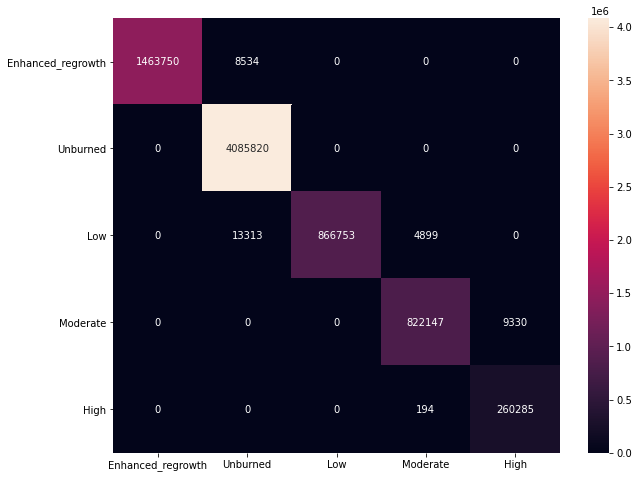

In [28]:
# Confusion Matrix
df_cm = pd.DataFrame(cf_matrix, index = ['Enhanced_regrowth', 'Unburned', 'Low', 'Moderate', 'High'], columns = ['Enhanced_regrowth', 'Unburned', 'Low', 'Moderate', 'High'])

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [29]:
clf.save_model('/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/empedrado_fire_model.txt')

## Loading Saved Model

In [30]:
bst = lgb.Booster(model_file='/content/drive/My Drive/spaceapps_data/empedrado_2016_2017/empedrado_fire_model.txt')

In [31]:
# pred = bst.predict(X_test)

# #argmax() method 
# pred = [np.argmax(line) for line in y_pred]

# #converting from float to integer
# pred=pred.astype(int)

In [32]:
# print(classification_report(y_test, pred))

In [33]:
f_pred = bst.predict(X)

In [34]:
#argmax() method 
f_pred = np.array([np.argmax(line) for line in f_pred])

#converting from float to integer
f_pred= f_pred.astype(int)

In [35]:
print(classification_report(y, f_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5889138
           1       0.99      1.00      1.00  16343279
           2       1.00      0.98      0.99   3539859
           3       0.99      0.99      0.99   3325909
           4       0.97      1.00      0.98   1041915

    accuracy                           1.00  30140100
   macro avg       0.99      0.99      0.99  30140100
weighted avg       1.00      1.00      1.00  30140100



In [36]:
y = y + 1
y = y.reshape(gt.shape[1:])

f_pred = f_pred + 1
f_pred = f_pred.reshape(gt.shape[1:])

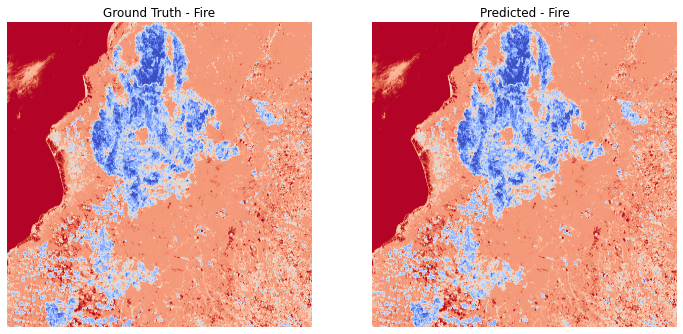

In [37]:
fig = plt.figure(figsize=(12, 20))
ax= fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].imshow(y, cmap='coolwarm_r')
ax[0].set_axis_off()
ax[0].title.set_text('Ground Truth - Fire')
ax[1].imshow(f_pred, cmap='coolwarm_r')
ax[1].title.set_text('Predicted - Fire')
ax[1].set_axis_off()
plt.show()

In [38]:
# final Image
f_img = gt.reshape(gt.shape[1:])
f_img = f_pred.reshape(sz)


In [39]:
f_img.shape

(1, 5490, 5490)

Predicted Fire Shape:  (5490, 5490)


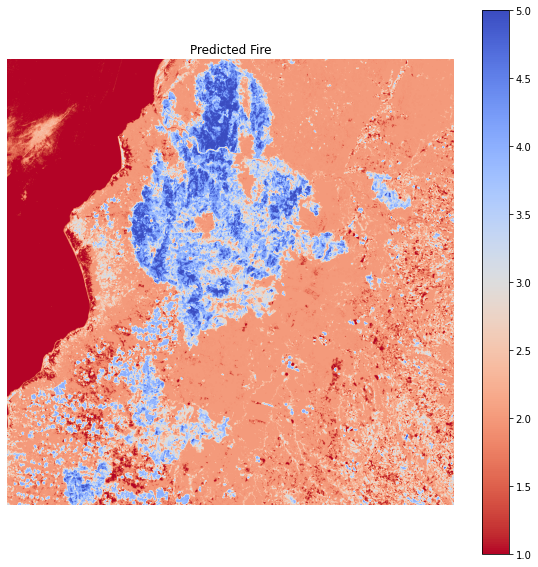

In [40]:
show_band(f_img.reshape(gt.shape[1:]), title='Predicted Fire', size=(10,10), cmap='coolwarm_r')